In [15]:
import pyPI as pi

In [2]:
import numpy as np
from scipy.linalg import eig
import sympy as sp

# Definición simbólica de la matriz
alpha, Delta_chi = sp.symbols('alpha Delta_chi', real=True)
M_alpha = sp.Matrix([
    [sp.cos(alpha)**2 + sp.exp(-1j*Delta_chi)*sp.sin(alpha)**2, (1 - sp.exp(-1j*Delta_chi))*sp.cos(alpha)*sp.sin(alpha)],
    [(1 - sp.exp(-1j*Delta_chi))*sp.cos(alpha)*sp.sin(alpha), sp.sin(alpha)**2 + sp.exp(-1j*Delta_chi)*sp.cos(alpha)**2]
])

# Conversión a numpy (para cálculo numérico)
def M_numeric(alpha_value, Delta_chi_value):
    return np.array(M_alpha.subs({alpha: alpha_value, Delta_chi: Delta_chi_value})).astype(complex)

# Parámetros de ejemplo
alpha_value = np.pi / 4   # 45°
Delta_chi_value = np.pi / 3  # 60° desfase

# Matriz evaluada numéricamente
M_eval = M_numeric(alpha_value, Delta_chi_value)

# Cálculo de autovalores y autovectores
eigenvalues, eigenvectors = eig(M_eval)

# Resultados
print("Matriz evaluada:")
print(M_eval)
print("\nAutovalores (componentes principales):")
print(eigenvalues)
print("\nAutovectores (direcciones principales):")
print(eigenvectors)


Matriz evaluada:
[[0.75-0.4330127j 0.25+0.4330127j]
 [0.25+0.4330127j 0.75-0.4330127j]]

Autovalores (componentes principales):
[1. +1.11022302e-16j 0.5-8.66025404e-01j]

Autovectores (direcciones principales):
[[ 0.70710678+0.00000000e+00j -0.70710678+1.11022302e-16j]
 [ 0.70710678+5.55111512e-17j  0.70710678+0.00000000e+00j]]


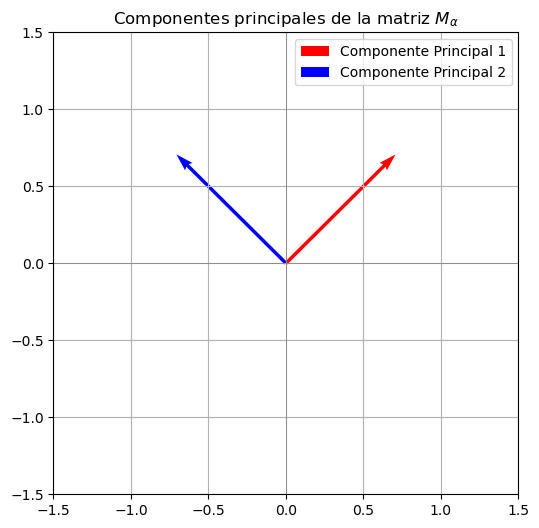

In [4]:
import matplotlib.pyplot as plt

# Visualización
plt.figure(figsize=(6, 6))
plt.quiver(0, 0, np.real(eigenvectors[0, 0]), np.real(eigenvectors[1, 0]), angles='xy', scale_units='xy', scale=1, color='r', label='Componente Principal 1')
plt.quiver(0, 0, np.real(eigenvectors[0, 1]), np.real(eigenvectors[1, 1]), angles='xy', scale_units='xy', scale=1, color='b', label='Componente Principal 2')

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.legend()

# Corrección de la sintaxis LaTeX
plt.title(r"Componentes principales de la matriz $M_{\alpha}$")

plt.grid(True)
plt.show()

In [14]:
import numpy as np
from scipy.linalg import eig
import sympy as sp

# Definición simbólica de la matriz
alpha, Delta_chi = sp.symbols('alpha Delta_chi', real=True)
M_alpha = sp.Matrix([
    [sp.cos(alpha)**2 + sp.exp(-1j*Delta_chi)*sp.sin(alpha)**2, (1 - sp.exp(-1j*Delta_chi))*sp.cos(alpha)*sp.sin(alpha)],
    [(1 - sp.exp(-1j*Delta_chi))*sp.cos(alpha)*sp.sin(alpha), sp.sin(alpha)**2 + sp.exp(-1j*Delta_chi)*sp.cos(alpha)**2]
])

# Conversión a numpy (para cálculo numérico)
def M_numeric(alpha_value, Delta_chi_value):
    return np.array(M_alpha.subs({alpha: alpha_value, Delta_chi: Delta_chi_value})).astype(complex)

# Parámetros de ejemplo
alpha_value = np.pi /32   # 45°
Delta_chi_value = np.pi / 3  # 60° desfase

# Matriz evaluada numéricamente
M_eval = M_numeric(alpha_value, Delta_chi_value)

# Cálculo de autovalores y autovectores
eigenvalues, eigenvectors = eig(M_eval)

# Determinación de alpha a partir del autovector principal
alpha_calculado = np.arctan2(np.real(eigenvectors[1, 0]), np.real(eigenvectors[0, 0]))

# Resultados
print("Autovector principal (dirección dominante):\n", eigenvectors[:, 0])
print(f"Ángulo calculado para α: {np.degrees(alpha_calculado):.2f}°")


Autovector principal (dirección dominante):
 [0.99518473+0.00000000e+00j 0.09801714-7.63278329e-17j]
Ángulo calculado para α: 5.62°


In [94]:
import numpy as np
from scipy.linalg import lstsq
import numpy as np
from numpy.linalg import inv

def calculate_matrix(input_vector, output_vector):
    # Verificamos que las dimensiones sean correctas
    if input_vector.shape != (2, 1) or output_vector.shape != (2, 1):
        raise ValueError("Los vectores deben ser de dimensión 2x1.")

    # Construir la matriz A usando el producto externo
    A = output_vector @ np.conjugate(input_vector.T)

    return A

In [91]:
import numpy as np

def calcular_alpha_desde_matriz(M):
    """
    Calcula el ángulo α a partir de una matriz de forma específica,
    correspondiente a una matriz birrefringente.

    Parámetros:
    -----------
    M : np.array
        Matriz 2x2 compleja que sigue la estructura del modelo óptico.

    Retorna:
    --------
    float
        Ángulo α en grados.
    """
    if M.shape != (2, 2):
        raise ValueError("La matriz debe ser de dimensión 2x2.")

    # Extraer elementos de la matriz
    M11, M12 = M[0, 0], M[0, 1]
    M21, M22 = M[1, 0], M[1, 1]

    # Determinación de α utilizando la relación adecuada
    alpha_calculado = 0.5 * np.arctan2(2 * np.abs(M21), np.abs(M11 - M22))

    return np.degrees(alpha_calculado)


In [92]:
# Vectores de entrada y salida
Int = pi.polarization_basis_set('L')
Out = pi.field_notation(pi.jones_matrix(np.pi/2, np.pi/4) @ Int)

In [88]:
Out

array([[0.+0.j],
       [1.+0.j]])

In [82]:
pi.jones_matrix(np.pi/2, np.pi/4)

array([[0.5-0.5j, 0.5+0.5j],
       [0.5+0.5j, 0.5-0.5j]])

In [81]:
pi.field_notation(Out)

array([[0.+0.j],
       [1.+0.j]])

In [95]:
# Calcular la matriz
M = calculate_matrix(Int, Out)

print("Matriz resultante A:")
print(M)

# Comprobación
calculated_output = pi.field_notation(M @ Int)
print("\nComprobación (A @ input_vector):")
print(calculated_output)
Out

Matriz resultante A:
[[0.        +0.j         0.        +0.j        ]
 [0.70710678+0.j         0.        -0.70710678j]]

Comprobación (A @ input_vector):
[[0.+0.j]
 [1.+0.j]]


array([[0.+0.j],
       [1.+0.j]])

In [96]:
calcular_alpha_desde_matriz(M)

31.717474411461005